# Libraries

In [13]:
# https://www.kaggle.com/dixhom/data-analysis-for-beginners

import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

# Feature Engineering

Here I have removed a number of features that will be surplus to requirements, using `to_drop`. 'season' has also been modified such that `'2002-03'` now appears as `'03'`. Furthermore, we can filter the data to remove null entries in `shot_made_flag`. For algorithms using strictly continuous data, all discrete features are filtered out. `shot_id` has been left in the data frame purely for indexing, it should not be used as a feature.


### `to_drop`
* `minutes_remaining` and `seconds_remaining` replaced with `secs_from_period_end` which is more useful.
* `team_id`, `team_name`, and `matchup` all contain effectively the same information because Kobe only played for one team and we have `opponent` as a feature.
* `lon` and `lat` represents the same data as `loc_x` and `loc_y` in a less clear format.
* `game_id` and `game_event_id`  is almost certainly independent of `shot_made_flag`. This can be proven (prove it)
* `game_date` is likely to be too specific to have a relationship `shot_made_flag`, so we will use `season` as our only time-based feature.
* `period` has been removed because the data represents extra time as its own period which makes the period irrelevant.
* `playoffs` has been removed since Kobe's shot accuracy between a play off game and non-play off game is the same to 2 decimal places, as demonstrated by Cai Yeming.

In [14]:
df = pd.read_csv("data.csv")

df['secs_from_period_end']   = 60*df['minutes_remaining']+df['seconds_remaining']
df['secs_from_period_start'] = 60*(11-df['minutes_remaining'])+(60-df['seconds_remaining'])
df['secs_from_start']   = (df['period'] <= 4).astype(int)*(df['period']-1)*12*60 + (df['period'] > 4).astype(int)*((df['period']-4)*5*60 + 3*12*60) + df['secs_from_period_start']
df['season'] = df['season'].apply(lambda x: x.split('-')[1] )

to_drop = ['period', 'minutes_remaining', 'seconds_remaining', 'team_id', 'team_name', 'matchup', 'lon', 'lat',
           'game_id', 'game_event_id', 'game_date']

df = df.drop(to_drop, axis = 1)
df = df[pd.notnull(df['shot_made_flag'])]

# establish relationship between playoffs and 

In [15]:
def draw_court(ax=None, color='black', lw=2, outer_lines=True):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

(270, -270)

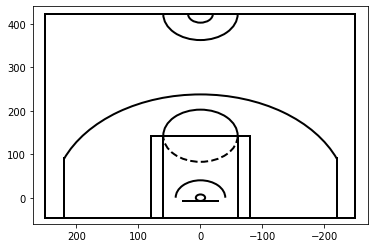

In [16]:
draw_court(); plt.ylim(-60,440); plt.xlim(270,-270)

In [17]:
# https://www.kaggle.com/apapiu/exploring-kobe-s-shots

data = df[['loc_x', 'loc_y', 'shot_made_flag']]

def test_it(data):
    clf = RandomForestClassifier(n_jobs=-1)  # A super simple classifier
    return cross_val_score(clf, data.drop('shot_made_flag', 1), data.shot_made_flag, scoring='roc_auc', cv=10)
test_it(data).mean()

NameError: name 'cross_val_score' is not defined

In [ ]:
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = nona.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

In [ ]:
X = df.drop(['shot_made_flag'], axis = 1)
y = df['shot_made_flag']

x_tr, x_test, y_tr, y_test = train_test_split(x, y, test_size = 0.3)